In [1]:
from surrogate.neighbor import GeneticAlgorithmPermutationGenerator, calculate_feature_values
from utils.prediction import PredictionTypeWrapper, PredictionTypeWrapper, generate_local_predictions, wrap_information
from surrogate.wrapper import SurrogateWrapper
from lore.prepare_dataset import prepare_diabetes_dataset

from utils import load
from datetime import datetime
import tensorflow as tf
import numpy as np
import pandas as pd

### Set random seed
seed = 123
tf.random.set_seed(seed)
np.random.seed(seed)

In [2]:
### Load data
dataset = load.SelectableDataset.Diabetes
data, balanced_data, X, Y, encoder, scaler, n_features, n_classes, feature_names, target_name = load.load_dataset(dataset)
X_train, Y_train, X_test, Y_test, X_validation, Y_validation = load.load_training_data(dataset)
model = load.load_trained_model_for_dataset(dataset)

Loaded model from disk


In [3]:
diabetes_feature_range = (X_train.min(axis=0), X_train.max(axis=0))
# store all information 
local_data_dict = generate_local_predictions( X_test, Y_test, model, scaler, encoder )
# sorting by different conditions
true_positives,true_negatives, false_positives, false_negatives = wrap_information( local_data_dict )
# get all prediction types
all_predictions = PredictionTypeWrapper(true_positives,true_negatives, false_positives, false_negatives)

In [4]:
surrogate_wrapper = SurrogateWrapper(model)
diabetes_dataset = prepare_diabetes_dataset('./datasets/diabetes.csv')

In [5]:
diabetes_dataset['continuous']

['Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age']

In [6]:
diabetes_dataset['discrete']

['Pregnancies', 'Outcome']

In [7]:
diabetes_dataset['feature_values'] = calculate_feature_values(balanced_data, list(balanced_data.columns), 'Outcome', ['Pregnancies'], size=1000)

In [8]:
idx_features = diabetes_dataset['idx_features']
discrete = diabetes_dataset['discrete']
continuous = diabetes_dataset['continuous']
target_name = diabetes_dataset['class_name']
feature_values = diabetes_dataset['feature_values']

In [9]:
generator = GeneticAlgorithmPermutationGenerator(idx_features, discrete, continuous, target_name, surrogate_wrapper, scaler)

In [10]:
x = np.array(list(balanced_data.iloc[5][:-1]))

In [11]:
surrogate_wrapper.predict(scaler.transform(x.reshape(1, -1)))

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.75471205]], dtype=float32)>

In [12]:
start = datetime.now()
permuatations = generator.generate_data(x, feature_values)
end = datetime.now()
print(end-start)

/Users/jrhs/miniforge3/envs/tf_mac/lib/python3.8/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Users/jrhs/miniforge3/envs/tf_mac/lib/python3.8/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
0:00:32.781636


In [13]:
permuataion_array = np.array(permuatations)

In [14]:
permutation_pred = surrogate_wrapper.predict(scaler.transform(permuataion_array))

In [15]:
np.unique(np.round(permutation_pred), return_counts=True)

(array([0., 1.], dtype=float32), array([546, 550]))

In [16]:
permuataion_array.shape

(1096, 8)

In [17]:
from sklearn.tree import DecisionTreeClassifier

In [18]:
tree = DecisionTreeClassifier(random_state=0)

In [27]:
tree.fit(permuataion_array, np.round(permutation_pred.numpy()))

DecisionTreeClassifier(random_state=0)

In [28]:
np.unique(tree.predict(permuataion_array), return_counts=True)

(array([0., 1.], dtype=float32), array([546, 550]))

In [42]:
from sklearn.tree import plot_tree

[Text(181.35000000000002, 199.32, 'Age <= 25.203\ngini = 0.5\nsamples = 1096\nvalue = [546, 550]\nclass = u'),
 Text(111.60000000000001, 163.07999999999998, 'DiabetesPedigreeFunction <= 1.631\ngini = 0.051\nsamples = 539\nvalue = [525, 14]\nclass = O'),
 Text(83.7, 126.83999999999999, 'Glucose <= 192.469\ngini = 0.011\nsamples = 528\nvalue = [525, 3]\nclass = O'),
 Text(55.800000000000004, 90.6, 'SkinThickness <= 1.983\ngini = 0.004\nsamples = 526\nvalue = [525, 1]\nclass = O'),
 Text(27.900000000000002, 54.359999999999985, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]\nclass = u'),
 Text(83.7, 54.359999999999985, 'gini = 0.0\nsamples = 525\nvalue = [525, 0]\nclass = O'),
 Text(111.60000000000001, 90.6, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]\nclass = u'),
 Text(139.5, 126.83999999999999, 'gini = 0.0\nsamples = 11\nvalue = [0, 11]\nclass = u'),
 Text(251.10000000000002, 163.07999999999998, 'DiabetesPedigreeFunction <= 0.634\ngini = 0.073\nsamples = 557\nvalue = [21, 536]\nclass = u'),
 Tex

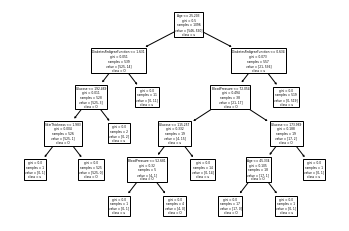

In [46]:
plot_tree(tree, feature_names=feature_names, class_names=target_name)

'Outcome'